# PWR Assembly Depletion

In this example, we will demonstrate how to perform a PWR assembly depletion simulation based on the 3.1% enriched assembly (without any burnable poison rods) from the BEAVRS benchmark. We can begin by importing all the tools we will need from Scarabée.

In [1]:
from scarabee import (
    NDLibrary,
    MaterialComposition,
    Material,
    Fraction,
    DensityUnits,
)
from scarabee.reseau import FuelPin, GuideTube, PWRAssembly, Symmetry
import numpy as np
import matplotlib.pyplot as plt

The `scarabee.reseau` submodule contains all of the elements needed for lattice physics calculations (reseau is French for lattice). In this case, we have directly imported only the classes needed for this example.

We can now create our Nuclear Data Library (NDL) object, and define the materials we will need for the fuel pins and guide tubes. In this example, we will not provide a path to the `NDLibrary` constructor, which means it will automatically look at our `SCARABEE_ND_LIBRARY` environment variable to find the path to the NDL.

In [2]:
ndl = NDLibrary()

# Define Fuel at 3.1 w/o enrichment
Fuel31Comp = MaterialComposition(Fraction.Atoms, name="Fuel 3.1%")
Fuel31Comp.add_leu(3.1, 1.0) # The add_leu method assumes weight enrichment !
Fuel31Comp.add_element("O", 2.0)
Fuel31 = Material(Fuel31Comp, 900.0, 10.30166, DensityUnits.g_cm3, ndl)

# Define the cladding
CladComp = MaterialComposition(Fraction.Weight, name="Zircaloy 4")
CladComp.add_element("O", 0.00125)
CladComp.add_element("Cr", 0.0010)
CladComp.add_element("Fe", 0.0021)
CladComp.add_element("Zr", 0.98115)
CladComp.add_element("Sn", 0.0145)
Clad = Material(CladComp, 575.0, 6.55, DensityUnits.g_cm3, ndl)

# Define the helium gas
HeComp = MaterialComposition(Fraction.Atoms, name="He Gas")
HeComp.add_element("He", 1.0)
He = Material(HeComp, 575.0, 0.0015981, DensityUnits.g_cm3, ndl)

In this simulation, we have assumed a fuel temperature of 900 K, and a cladding and gas temperature of 575 K. You might have noticed that we have not defined any moderator material. This will be taken care of automatically by the `PWRAssembly` class later on.

The next step is to define the fuel pin and guide tubes.

In [3]:
# Create a fuel pin
fp = FuelPin(
    fuel=Fuel31,
    fuel_radius=0.39218,
    gap=He,
    gap_radius=0.40005,
    clad=Clad,
    clad_radius=0.45720,
)

# Create a guide tube
gt = GuideTube(inner_radius=0.56134, outer_radius=0.60198, clad=Clad)

Now we need to define the arrangement of the fuel pins and guide tubes in the assembly. The full 2D assembly would normally be 17x17, but since the assembly is symmetric, we can use quarter symmetry to reduce the size of the problem (and get results faster). When running with quarter symmetry, the the left hand side (-x) and the bottom (-y) pins will be half pin cells (because our full assembly had an odd number of pins on each side).

In [4]:
#         |--- Half pin cells
#         v
cells = [[fp, fp, fp, fp, fp, fp, fp, fp, fp],
         [fp, fp, fp, fp, fp, fp, fp, fp, fp],
         [gt, fp, fp, gt, fp, fp, fp, fp, fp],
         [fp, fp, fp, fp, fp, gt, fp, fp, fp],
         [fp, fp, fp, fp, fp, fp, fp, fp, fp],
         [gt, fp, fp, gt, fp, fp, gt, fp, fp],
         [fp, fp, fp, fp, fp, fp, fp, fp, fp],
         [fp, fp, fp, fp, fp, fp, fp, fp, fp],
         [gt, fp, fp, gt, fp, fp, gt, fp, fp]] # <- Half pin cells


It is now time to define the `PWRAssembly` object, which will be responsible for orchestrating the entire depletion calculation. It requires all the assembly information (such a pin pitch, assembly pitch, moderator parameters, linear power density, and more). We will assume the moderator is at 575 K and a pressure of 15.5132 MPa with a soluble boron concentration of 975 parts per million. By default, Scarabée assumes a linear power density of 42 kW/cm, which is reasonable for most PWRs, and we have kept this choice. Keep in mind that **the linear power density that is provided is for the linear power of the entire assembly** and not just for a single fule pin !

In [5]:
asmbly = PWRAssembly(
    pitch=1.25984,
    assembly_pitch=21.50364,
    shape=(17, 17),
    symmetry=Symmetry.Quarter,
    moderator_pressure=15.5132,
    moderator_temp=575.0,
    boron_ppm=975.0,
    cells=cells,
    ndl=ndl,
)

At this point, if we were to call `asmbly.solve()`, it would run a single k-eigenvalue problem, and not actually perform any depletion. For that, we need to tell it what the series of time steps should be. We can either set `asmbly.depletion_time_steps` to be an array containing the durration of all time steps in days, or we can set `asmbly.depletion_exposure_steps` to be an array containing the durration of all time steps in MWd/kg of initial heavy mental. We will use the later of these two option here:

In [6]:
asmbly.depletion_exposure_steps = np.array(5*[0.01] + [0.15] + [0.8] + [1.] + 15*[2.])

The first few time steps are rather small (on the order of about 0.5 days). This is to accurately predict the build up of strong fission product poisons, particularly Xe-135.

Scarabée uses an LE/QI predictor-corrector method for depletion. That means for each time step a transport calculation is performed for the predictor *and* the corrector. This is the most accurate option, but it might not be necessary for your problem. In our case, we don't have any burnable poisons so we likely don't need to perform a second transport calcualtion on the corrector step. We will instead just use the flux from the predictor step with the nuclide concentrations obtained with the predictor step. This will help the simulation run almost twice as fast, but should likely only be used if you know what you are doing.

In [7]:
asmbly.corrector_transport = False

We can now finally launch the simulation, which will take approximately 10-30 minutes depending on your computer and the group strucutre.

In [8]:
asmbly.solve()

[info] 
[info] ------------------------------------------------------------
[info] Running Time Step 0
[info] Exposure: 0.000E+00 MWd/kg
[info] Time    : 0.000E+00 days
[info] 
[info] Predictor:
[info] Initializing Dancoff correction calculation components.
[info] Computing Dancoff corrections for the fuel.
[info] Computing Dancoff corrections for the cladding.
[info] Creating quadrature
[info] Number of azimuthal angles: 64
[info] Maximum track spacing: 0.05 cm
[info] Tracing tracks
[info] Renormalizing segment lengths
[info] Determining track connections
[info] Time spent drawing tracks: 0.088601 s.
[info] 
[info] Kinf: 1.20997
[info] 
[info] Performing P1 criticality spectrum calculation
[info] Kinf    : 1.20997
[info] Buckling: 0.00355
[info] 
[info] Corrector:
[info] 
[info] Performing P1 criticality spectrum calculation
[info] Kinf    : 1.19067
[info] Buckling: 0.00325
[info] 
[info] ------------------------------------------------------------
[info] Running Time Step 1
[info] Ex

Now comes the fun part: making plots ! Let's first take a look at $k_\text{eff}$ as a function of the burn-up of the assembly:

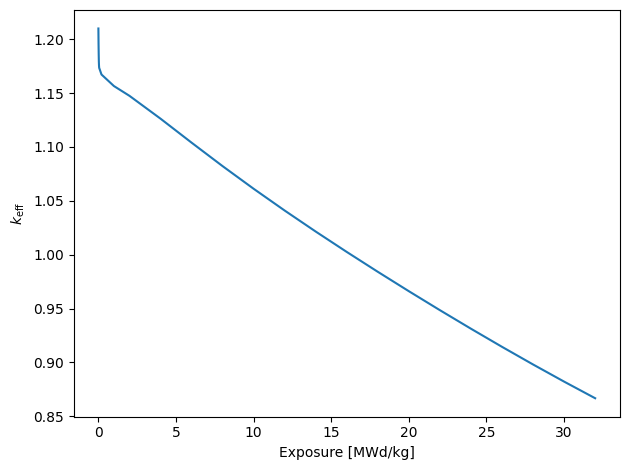

In [9]:
plt.plot(asmbly.exposures, asmbly.keff)
plt.xlabel("Exposure [MWd/kg]")
plt.ylabel(r"$k_\text{eff}$")
plt.tight_layout()
plt.show()

At the beginning, there is a sharp decrease in reactivity due to the Xe-135 build up, but then the reactivity decreases in almost a linear fashion with burn-up (which is where the linear reactivity model for fuel management comes from). In addition to the reactivity, we can also look at our fuel composition. Helper methods are provided to obtain the average atom density of a desired nuclide in all the fuel across the assembly. Let's look at just a few important ones:

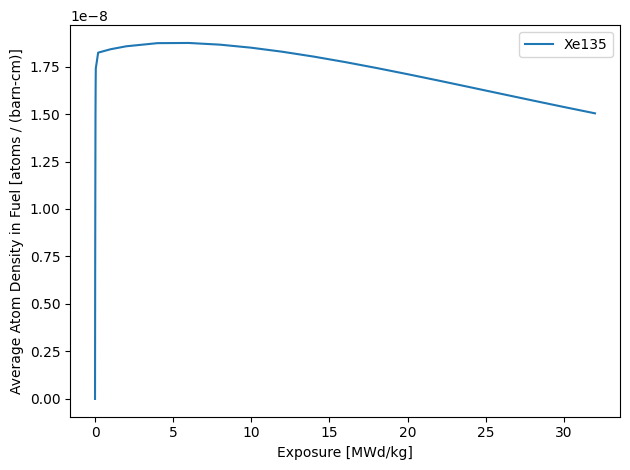

In [10]:
U235 = np.zeros(asmbly.exposures.size)
U238 = np.zeros(asmbly.exposures.size)
Pu239 = np.zeros(asmbly.exposures.size)
Xe135 = np.zeros(asmbly.exposures.size)
for t in range(asmbly.exposures.size):
    U235[t] = asmbly.get_average_fuel_nuclide_density(t, "U235")
    U238[t] = asmbly.get_average_fuel_nuclide_density(t, "U238")
    Pu239[t] = asmbly.get_average_fuel_nuclide_density(t, "Pu239")
    Xe135[t] = asmbly.get_average_fuel_nuclide_density(t, "Xe135")

plt.plot(asmbly.exposures, Xe135, label="Xe135")
plt.xlabel("Exposure [MWd/kg]")
plt.ylabel("Average Atom Density in Fuel [atoms / (barn-cm)]")
plt.legend()
plt.tight_layout()
plt.show()

Here, we can see the rapid build up of Xe-135. Let's take a look at U-235 and Pu-239 next:

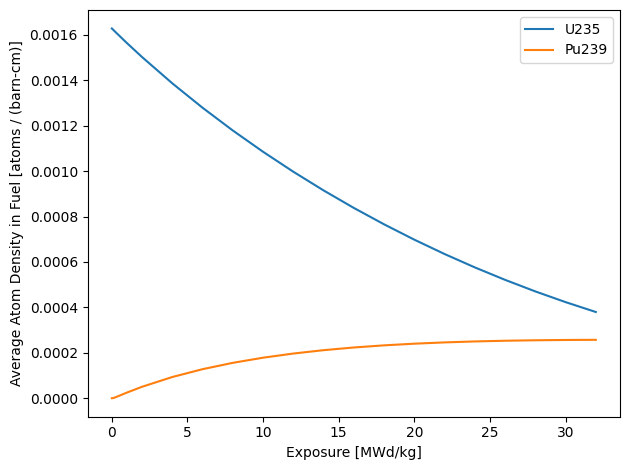

In [11]:
plt.plot(asmbly.exposures, U235, label="U235")
plt.plot(asmbly.exposures, Pu239, label="Pu239")
plt.xlabel("Exposure [MWd/kg]")
plt.ylabel("Average Atom Density in Fuel [atoms / (barn-cm)]")
plt.legend()
plt.tight_layout()
plt.show()

At a burn-up of 30 MWd/kg, we can see that there is now a comparable amount of Pu-239 and U-235. Lastly, we can look at how the quantity of U-238 has decreased:

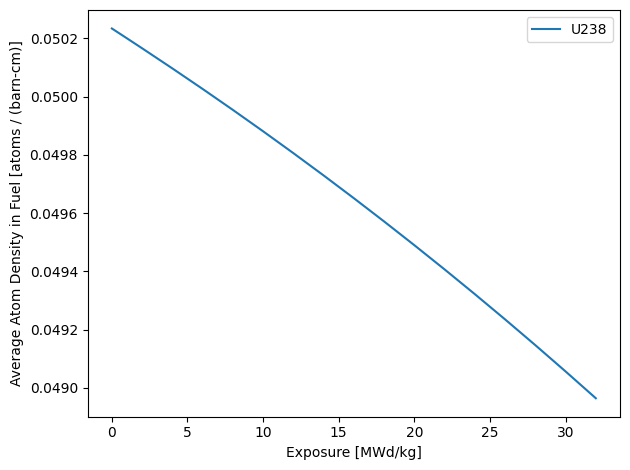

In [12]:
plt.plot(asmbly.exposures, U238, label="U238")
plt.xlabel("Exposure [MWd/kg]")
plt.ylabel("Average Atom Density in Fuel [atoms / (barn-cm)]")
plt.legend()
plt.tight_layout()
plt.show()

There are many other things which can be done with Scarabée, but this should be sufficient for you to get started with lattice physics calculations !